In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import rescale, resize, radon, iradon

import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import argrelextrema
from scipy.optimize import root, leastsq

import sys
from utils import * #add_noise, snr_calc, DC_and_SYM, fit
import h5py

In [12]:
#h_sino = h5py.File('./sinograms/tomo_00001/tomo_00001.h5', 'r')
h_sino = h5py.File('./sinograms/tomo_00064_to_00067/tomo_00067.h5', 'r')

def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))


h_sino.visititems(print_attrs)
data = h_sino['/exchange/data'][()]
data_axes = h_sino['/exchange/data'].attrs['axes']
print(data_axes,' = ',data.shape)
theta = h_sino['/exchange/theta'][()]
print(max(theta))

exchange
exchange/data
    units: b'counts'
    axes: b'theta:y:x'
    description: b'transmission'
exchange/data_dark
    units: b'counts'
    axes: b'theta_dark:y:x'
exchange/data_white
    units: b'counts'
    axes: b'theta_white:y:x'
exchange/theta
    units: b'degrees'
exchange/title
implements
measurement
measurement/instrument
measurement/instrument/acquisition
measurement/instrument/acquisition/comment
measurement/instrument/acquisition/mode
measurement/instrument/detector
measurement/instrument/detector/x_actual_pixel_size
    units: b'microns'
measurement/instrument/detector/y_actual_pixel_size
    units: b'microns'
measurement/instrument/monochromator
measurement/instrument/monochromator/energy
    units: b'keV'
measurement/instrument/source
measurement/instrument/source/beamline
measurement/instrument/source/current
    units: b'mA'
measurement/instrument/source/datetime
measurement/instrument/source/mode
measurement/instrument/source/name
measurement/sample
measurement/sam

In [56]:
## For simulated data clip pixel values to >0 for realistic noise
#clip = 10000
#sinogram = np.clip(np.load('sinogram_off_center.npy'),clip, None)

## Define exposure
# for single sinogram, exposure is 1:1 noise to signal
# for summed sinograms exposure is 1:Y noise to signal where y is the dimension of y axis
#exposure = None
exposure = 1*data.shape[1]

## Choose to sum along Y axis or to select a slice
added = np.sum(data ,axis = 1)            #sum along Y axis
sinogram = np.transpose(added)
sinogram_slice, sinogram_slice_snr = add_noise(np.transpose(data[:,100,:]), exposure)
#sinogram = np.transpose(data[:,650//2,:])  #select a slice

## Add noise
sinogram_n, sinogram_noise_snr = add_noise(sinogram, exposure)


## Sum along theta
rowsum = np.sum(sinogram, axis=1)
rowsum_n = np.sum(sinogram_n, axis=1)

## find min via corss corr

#print(cross_correlate(rowsum))

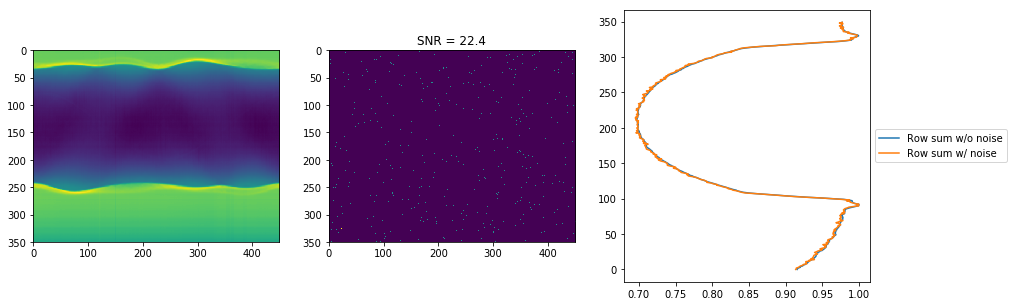

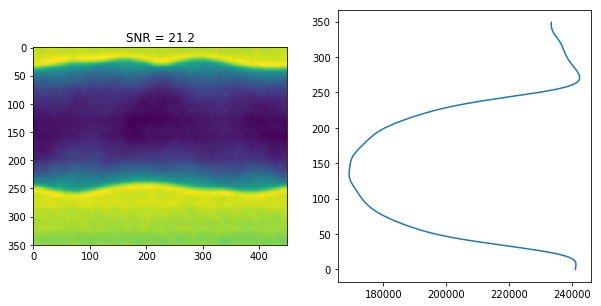

24728140
22.48855564754869


In [57]:
## Plot ##
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(sinogram)
plt.subplot(132)
plt.imshow(sinogram_noise)
plt.title('SNR = ' + str(sinogram_noise_snr)[0:4])
plt.subplot(133)
plt.plot(rowsum[::-1]/np.max(rowsum), np.arange(0,sinogram.shape[0],1), label = 'Row sum w/o noise')
plt.plot(rowsum_n[::-1]/np.max(rowsum_n), np.arange(0,sinogram.shape[0],1), label = 'Row sum w/ noise')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

plt.figure(figsize = (10,5))
plt.subplot(121)
plt.imshow(gaussian_filter(sinogram_slice, sigma=5))
plt.title('SNR = ' + str(sinogram_slice_snr)[0:4])
plt.subplot(122)
plt.plot(np.sum(gaussian_filter1d(sinogram_slice, sigma=10, axis=0), axis = 1), np.arange(0,sinogram.shape[0],1))
plt.show()

print(np.max(sinogram))
print(sinogram_noise_snr)

# Shift the Detector

In [58]:
## Define scan area and range
scan_area = int(sinogram.shape[0]/2)
shifting_range = sinogram.shape[0]-scan_area

## Add noise
sinogram_noise = add_noise(sinogram, exposure)[0]
## Shift scan_area through sinogram and extract the DC and SYM frequencies for each shift
DC_all, SYM_all = shift(sinogram_noise, scan_area)

# Plot DC, SYM and their even and odd Components

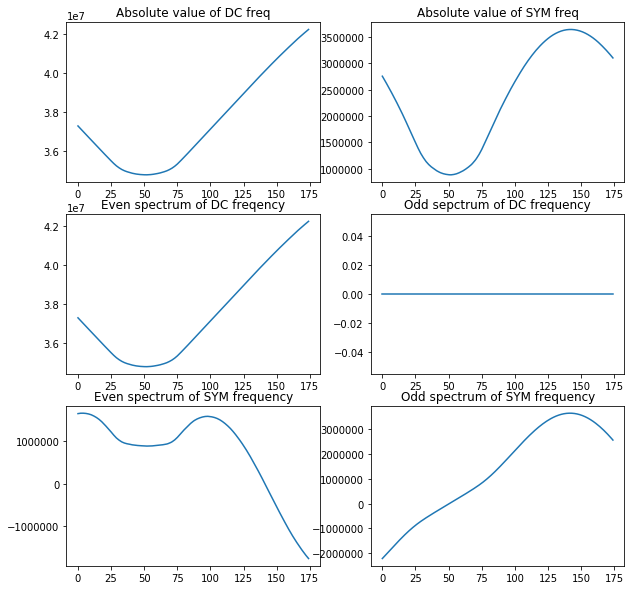

In [59]:
plot_DC_and_SYM(DC_all, SYM_all)


# Fit SYM_odd to polynomial and find root

Minimum of Dataset =  [138.5]
Polynomial Root =  [137.99910251]


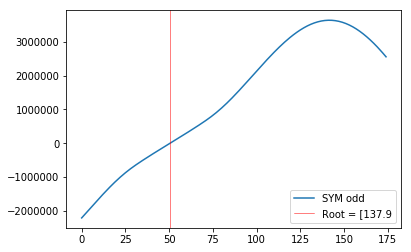

In [60]:
root_poly = SYM_odd_root_poly(np.imag(SYM_all), scan_area, 5)
data_min = SYM_odd_data_min(np.imag(SYM_all), scan_area)
N = len(np.imag(SYM_all))

print('Minimum of Dataset = ', data_min)
print('Polynomial Root = ', root_poly)

plt.figure()
plt.plot(np.imag(SYM_all), label = 'SYM odd')
plt.axvline(root_poly[0]-scan_area/2, color='r', linewidth = '.5', label = 'Root = ' + str(root_poly)[0:6])
plt.legend()
plt.show()

/home/everett/Research/18-19/tomography/Dosefrac/rotationCenter/utils.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  snr = np.mean(array)/np.std(noise-array)


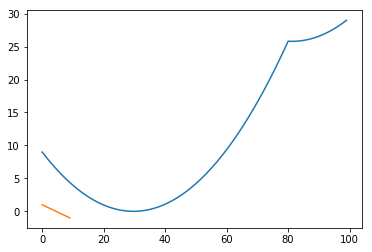

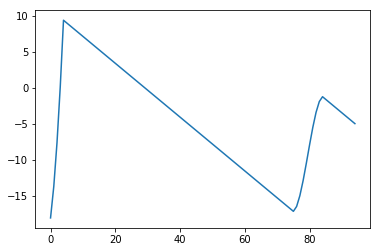

In [58]:
from scipy import signal
from skimage import restoration

start = 20
xrange = 100
exposure = None


#sq = np.zeros(10)
#sq[0:1]=8
#sq[1+1:100]=-8
#sq[50:55] = 8
#sq = -((np.arange(10)-50)*2)**2
#sq += np.abs(np.min(sq)*2)

window = 10
sq = -np.linspace(-1,1,window)
#sq= (np.linspace(-1,1,window))**2
c = ((np.linspace(0,10,100)-3))**2
c[80:100] += -np.linspace(0,20,20)
curve = add_noise(c, exposure)[0]
valconv = []

square_size = 0
'''
for i in range(xrange-square_size):
    #c = ((np.linspace(0,10,100)-i/10)*2)**2
    #curve = np.random.poisson(c*exposure /np.max(c))
    sq = np.zeros(100)
    #sq[i:i+square_size]=8
    #sq[i+1:100]=-8
    sq = (np.linspace(-1,1,100)-5+i/10)
    #sq = np.sin(np.linspace(0,2*np.pi,100)+np.pi*i/100)
    valconv.append(np.correlate(sq,curve))
'''
plt.plot(curve)
plt.plot(sq)
plt.show()

conv = np.correlate(curve, sq, mode = 'full')
plt.plot(conv[5:100])
plt.show()

101
True Min: = 30
[]
[]


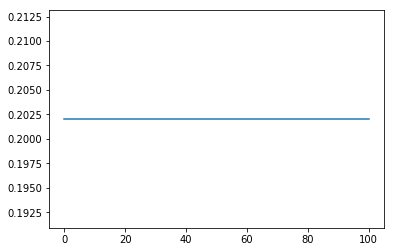

In [55]:
rt, fitted = SYM_odd_root_poly(conv[20:100], window,1)
print(len(conv))


argext = argrelextrema(conv, np.greater)[0]
argextmin = argrelextrema(fitted(np.arange(len(conv))), np.less)[0] - window/2
print('True Min: = 30')
print(rt)
print(argextmin)

plt.plot(fitted(np.arange(len(conv))))
plt.show()

/home/everett/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


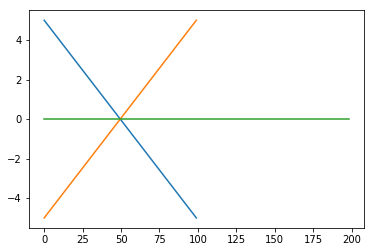

In [11]:
c = (np.linspace(0,10,100)-5)
fc = np.fft.fft(c)
dcsym = fc*-1j#np.zeros(100)*0j
#fc2 = #np.zeros(100)*0j

#for i in range(50):
#    dcsym[2*i+1] = fc[i]
#    fc2[2*i] = fc[i]
a = np.fft.ifft(dcsym)
b = np.fft.ifft(fc)
plt.plot(np.imag(a))
plt.plot(c)
plt.plot(np.correlate(b,a, mode='full'))
plt.show()

In [5]:
print(fitted())

 
0.001206 x - 0.1297
